In [1]:
import optuna
import pickle
import torch
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from matplotlib.ticker import MultipleLocator
from scipy.optimize import linear_sum_assignment
import matplotlib.colors as colors


# Add the root folder to Python path
root_folder = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_folder not in sys.path:
    sys.path.append(root_folder)

import lib.unet_nn as UNet
import lib.modified_aggregation as MA
from lib.modified_aggregation_clusterer import ModifiedAggregationClusterer
from lib.unet_clusterer import UNetClusterer
from lib.focal import FocalH
from lib.base_nn import Data
from lib import metrics# import count_clusters, count_labels, compute_score, total, separation_efficiency

os.chdir('/home/bjartur/workspace/python_focalh_clustering/') # Laptop and Desktop

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size" : 15,
    "legend.fontsize" : 12,
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.major.size" : 5.0,
    "xtick.minor.size" : 3.0,
    "ytick.major.size" : 5.0,
    "ytick.minor.size" : 3.0,
    "axes.linewidth" : 0.8,
    "legend.handlelength" : 2,
})

# Evaluation files

In [3]:
evals = dict()

evals["ma"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/ma/eval_ma_train_tiny_eval.pkl",
    "name": "Modified Aggregation",
    "name_short": "ma",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:blue",
    "default_plot_marker": "o",
    "default_line_style": "dashed"
}

evals["cnn"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/cnn/eval_cnn_train_tiny_eval.pkl",
    "name": "CNN+Modified Aggregation",
    "name_short": "cnn",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:orange",
    "default_plot_marker": "v",
    "default_line_style": "dashed"
}

evals["dbscan"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/dbscan/eval_dbscan_train_tiny_eval.pkl",
    "name": "DBSCAN",
    "name_short": "dbscan",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:green",
    "default_plot_marker": "1",
    "default_line_style": "dashed"
}

evals["hdbscan"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/hdbscan/eval_hdbscan_train_tiny_eval.pkl",
    "name": "HDBSCAN",
    "name_short": "hdbscan",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:red",
    "default_plot_marker": "s",
    "default_line_style": "dashed"
}


evals["optics"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/optics/eval_optics_train_tiny_eval_small.pkl",
    "name": "OPTICS",
    "name_short": "optics",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:purple",
    "default_plot_marker": "p",
    "default_line_style": "dashed"
}

evals["affinity_propagation"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/affinity_propagation/eval_affinity_propagation_train_tiny_eval.pkl",
    "name": "Affinity Propagation",
    "name_short": "affinity_propagation",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:brown",
    "default_plot_marker": "+",
    "default_line_style": "dashed"
}


evals["kmeans"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/kmeans/eval_kmeans_train_tiny_eval.pkl",
    "name": "Oracle+K-means",
    "name_short": "kmeans",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:pink",
    "default_plot_marker": "d",
    "default_line_style": "dotted"
}

evals["birch"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/birch/eval_birch_train_tiny_eval.pkl",
    "name": "Oracle+BIRCH",
    "name_short": "birch",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:grey",
    "default_plot_marker": "2",
    "default_line_style": "dotted"
}

evals["agglomerative"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/agglomerative/eval_agglomerative_train_tiny_eval.pkl",
    "name": "Oracle+Agglomerative Clustering",
    "name_short": "agglomerative",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:olive",
    "default_plot_marker": "3",
    "default_line_style": "dotted"
}

evals["gmm"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/gmm/eval_gauss_train_tiny_eval.pkl",
    "name": "Oracle+Gaussian Mixture Model",
    "name_short": "gmm",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "tab:cyan",
    "default_plot_marker": "<",
    "default_line_style": "dotted"
}

evals["spectral"] = {
#    "file": "evaluation/eval_ma_two_15092025_130928.pkl",
    "file": "evaluation/best/spectral/eval_spectral_train_tiny_eval.pkl",
    "name": "Oracle+Spectral",
    "name_short": "spectral",
    "opt": "separation",
    "train": "train_tiny",
    "default_plot_color": "black",
    "default_plot_marker": ">",
    "default_line_style": "dotted"
}

def load_bundle(eval_dict):
    with open(eval_dict["file"], "rb") as f:
        loaded_bundle = pickle.load(f)
    #eval_dict["data"] = loaded_bundle
    return loaded_bundle

# Separation

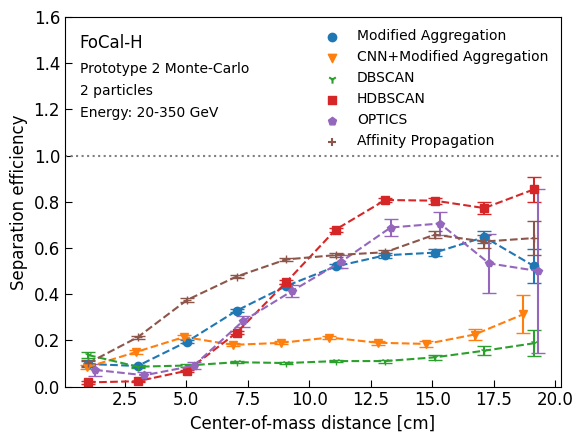

In [63]:
lst = ["ma", "cnn", "dbscan", "hdbscan", "optics", "affinity_propagation"]
#lst = ["ma"]#, "cnn", "dbscan", "hdbscan", "optics", "affinity_propagation"]


def dist(coms):
    dists = [None]*len(coms)
    for i in range(len(coms)):
        diff = coms[i][:, np.newaxis, :] - coms[i][np.newaxis, :, :]
        dist = np.sqrt((diff ** 2).sum(axis=-1))
        upper_tri = dist[np.triu_indices_from(dist, k=1)]
        dists[i] = upper_tri.mean()
    return dists

def standard_error_of_proportion(p,n):
    return np.sqrt((p*(1-p))/n)

def plot_separation(df,Nbins,ax, marker_shape="^", linestyle="", color=""):

#    mask = df["data"]["eval"]["particles"] == 2

    data = load_bundle(df)

    x_list = []
    y_list = []
    for i,e in enumerate(data["eval"]["coms"]):
        if len(e)==2:
            x_list.append(e)
            y_list.append(data["eval"]["separation"][i])
    x = np.array(dist(x_list))
    
    bins = np.linspace(min(x), max(x), Nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mu_y = np.zeros(Nbins)
    sigma_y = np.zeros(Nbins)
    y = np.array(y_list)

    for i in range(Nbins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            mu_y[i] = y[mask][:,0].sum() / y[mask][:,1].sum()
            sigma_y[i] = standard_error_of_proportion(mu_y[i], y[mask][:,1].sum())
    
    ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker = marker_shape, linestyle=linestyle, color=color, capsize=5)


fig,ax = plt.subplots()

Nbins=10

for l in lst:
    load_bundle(evals[l])
    plot_separation(evals[l],Nbins, ax
                    , marker_shape=evals[l]["default_plot_marker"]
                    , linestyle=evals[l]["default_line_style"]
                    , color=evals[l]["default_plot_color"]
                   )
    ax.scatter([],[], marker=evals[l]["default_plot_marker"]
               , color=evals[l]["default_plot_color"]
               , label=evals[l]["name"])


ax.axhline(1, color="grey", linestyle="dotted")

ax.set_ylim(0,1.6)

ax.legend(framealpha=0)
ax.set_xlabel("Center-of-mass distance [cm]")
ax.set_ylabel("Separation efficiency")

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"2 particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
#ax.text(0.03, 0.68, f"{format_with_suffix(len(df_ma))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)

fig.savefig("sep_eff_non_parametric.png", bbox_inches="tight")

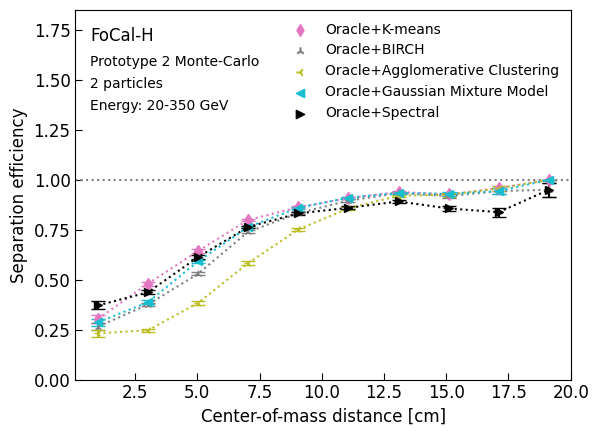

In [62]:
lst = ["kmeans", "birch", "agglomerative", "gmm", "spectral"]

fig,ax = plt.subplots()

Nbins=10

for l in lst:
    load_bundle(evals[l])
    plot_separation(evals[l],Nbins, ax
                    , marker_shape=evals[l]["default_plot_marker"]
                    , linestyle=evals[l]["default_line_style"]
                    , color=evals[l]["default_plot_color"]
                   )
    ax.scatter([],[], marker=evals[l]["default_plot_marker"]
               , color=evals[l]["default_plot_color"]
               , label=evals[l]["name"])


ax.axhline(1, color="grey", linestyle="dotted")

ax.set_ylim(0,1.85)

ax.legend(framealpha=0)
ax.set_xlabel("Center-of-mass distance [cm]")
ax.set_ylabel("Separation efficiency")

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"2 particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
#ax.text(0.03, 0.68, f"{format_with_suffix(len(df_ma))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)

fig.savefig("sep_eff_parametric.png", bbox_inches="tight")

# Efficiency

In [67]:
def plot_efficiency_chunks(x, y, Nbins, label, marker_shape=".", linestyle="solid", color="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    bins = np.linspace(x.min(), x.max(), Nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mu_y = np.zeros(Nbins)
    sigma_y = np.zeros(Nbins)

    for i in range(Nbins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            mu_y[i] = np.mean(y[mask])
            sigma_y[i] = np.std(y[mask]) / np.sqrt(np.sum(mask))

    if color == "":
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, capsize=5)
    else:
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, color=color, capsize=5)



def plot_efficiency(x, y, label, marker_shape=".", linestyle="solid", color="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    #bins = np.linspace(x.min(), x.max(), Nbins + 1)
    #bin_centers = (bins[:-1] + bins[1:]) / 2
    mu_y = np.zeros(Nbins)
    sigma_y = np.zeros(Nbins)

    for i in range(len(set(x))):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            mu_y[i] = np.mean(y[mask])
            sigma_y[i] = np.std(y[mask]) / np.sqrt(np.sum(mask))

    if color == "":
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, capsize=5)
    else:
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, color=color, capsize=5)

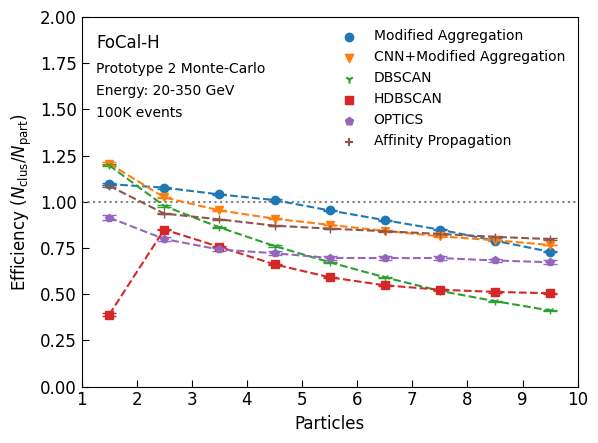

In [69]:
lst = ["ma", "cnn", "dbscan", "hdbscan", "optics", "affinity_propagation"]
#lst = ["ma"]#, "cnn", "dbscan", "hdbscan", "optics", "affinity_propagation"]
fig,ax = plt.subplots()

Nbins = 9

for l in lst:
    data = load_bundle(evals[l])
    y = data["eval"]["efficiency"]
    x = data["eval"]["particles"]
    plot_efficiency_chunks(x=x, y=y, Nbins=Nbins, label=evals[l]["name"]
                    , marker_shape=evals[l]["default_plot_marker"]
                    , linestyle=evals[l]["default_line_style"]
                    , color=evals[l]["default_plot_color"], ax=ax)
    ax.scatter([],[], label=evals[l]["name"], marker=evals[l]["default_plot_marker"], color=evals[l]["default_plot_color"])

ax.set_ylim(0,2)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], ["1","2","3","4","5","6","7","8","9","10"])
ax.set_ylabel("Efficiency ($N_{\\text{clus}}/N_{\\text{part}}$)")
ax.set_xlabel("Particles")
ax.axhline(1, color="grey", linestyle="dotted")
ax.legend(framealpha=0)
ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
#ax.text(0.03, 0.80, f"1-10 particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"100K events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)

fig.savefig("eff_particles.png", bbox_inches="tight")

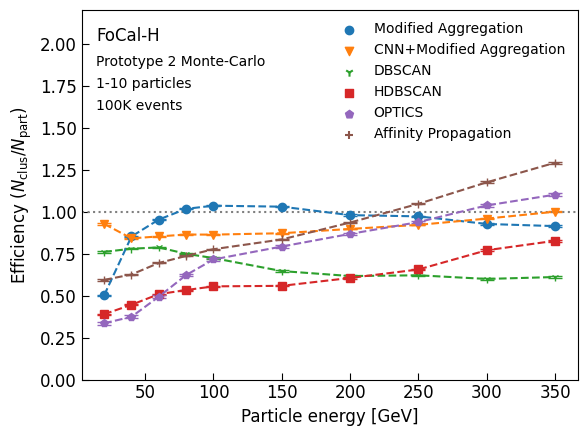

In [72]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size" : 12,
    "legend.fontsize" : 10,
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.major.size" : 5.0,
    "xtick.minor.size" : 3.0,
    "ytick.major.size" : 5.0,
    "ytick.minor.size" : 3.0,
    "axes.linewidth" : 0.8,
    "legend.handlelength" : 2,
})

lst = ["ma", "cnn", "dbscan", "hdbscan", "optics", "affinity_propagation"]
#lst = ["ma"]#, "cnn", "dbscan", "hdbscan", "optics", "affinity_propagation"]
fig,ax = plt.subplots()

Nbins = 9

for l in lst:
    data = load_bundle(evals[l])
    y = data["eval"]["efficiency"]
    x = data["eval"]["avg_energy"]
    mu_x = []
    mu_y = []
    sigma_y = []

    ens = set(x)
    
    for en in ens:
        mask = x == en
        mu_x.append(x[mask].mean())
        tmu_y = y[mask].mean()
        tsigma_y = y[mask].std()
        mu_y.append(tmu_y)
        sigma_y.append(tsigma_y/np.sqrt(len(y[mask])))

    sorted_idx = np.argsort(mu_x)

    mu_x_sorted = np.array(mu_x)[sorted_idx]
    mu_y_sorted = np.array(mu_y)[sorted_idx]
    sigma_y_sorted = np.array(sigma_y)[sorted_idx]
    
#    ax.scatter(mu_x_sorted, mu_y_sorted)
    ax.errorbar(mu_x_sorted, mu_y_sorted, yerr=sigma_y_sorted, marker=evals[l]["default_plot_marker"], linestyle=evals[l]["default_line_style"], capsize=5)
    ax.scatter([],[], label=evals[l]["name"], marker=evals[l]["default_plot_marker"], color=evals[l]["default_plot_color"])


ax.set_ylabel("Efficiency ($N_{\\text{clus}}/N_{\\text{part}}$)")
ax.set_xlabel("Particle energy [GeV]")



ax.set_ylim(0,2.2)
ax.axhline(1, color="grey", linestyle="dotted")
ax.legend(framealpha=0)
ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"1-10 particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"100K events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
#ax.text(0.03, 0.74, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)

fig.savefig("eff_energy.png", bbox_inches="tight")

In [6]:
ma_data = load_bundle(evals["ma"])

In [20]:
ma_data["eval"]["avg_energy"]

array([350., 350., 350., ...,  20.,  20.,  20.])

In [10]:
for key,item in ma_data["eval"].items():
    print(key)

x
y
values
labels
energy
coms
adj
iadj
tags
separation_efficiency
energy_pairs
tag_coms
label_coms
matched_indices
data
efficiency
separation
vmeasure
coverage
particles
avg_energy


In [ ]:
#lst = ["ma", "cnn", "dbscan", "hdbscan", "optics", "affinity_propagation"]
lst = ["ma"]#, "cnn", "dbscan", "hdbscan", "optics", "affinity_propagation"]
fig,ax = plt.subplots()
ax.set_ylim(0,1.5)
Nbins = 9

for l in lst:
    data = load_bundle(evals[l])
    y = data["eval"]["efficiency"]
    x = data["eval"]["particles"]
    plot_efficiency(x=x, y=y, Nbins=Nbins, label=evals[l]["name"]
                    , marker_shape=evals[l]["default_plot_marker"]
                    , color=evals[l]["default_plot_color"], ax=ax)

# Migration Matrix

Maybe they are called heatmap scatter plots?

In [4]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size" : 12,
    "legend.fontsize" : 12,
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.major.size" : 5.0,
    "xtick.minor.size" : 3.0,
    "ytick.major.size" : 5.0,
    "ytick.minor.size" : 3.0,
    "axes.linewidth" : 0.8,
    "legend.handlelength" : 2,
})

def migration_matrix(data, Nbins, E_min, E_max, ax=None, particles=None):

    if ax==None:
        fig,ax = plt.subplots()

    pairs_list = []
    if particles is not None:
        for i,e in enumerate(data["eval"]["particles"]):
            if e == particles:
                pairs_list.append(data["eval"]["energy_pairs"][i])
        pairs = np.concatenate(pairs_list)
    else:
        pairs = np.concatenate(data["eval"]["energy_pairs"])
    
    bins = np.linspace(E_min-50, E_max, Nbins)
    migration_matrix, xedges, yedges = np.histogram2d(
        pairs[:,1], pairs[:,0], bins=[bins, bins]
    )
    norm = colors.LogNorm(vmin=1, vmax=migration_matrix.max())
    #plt.figure(figsize=(8, 6))
    im = ax.imshow(
        migration_matrix.T,  # Transpose to match the orientation of true vs reconstructed
        origin="lower",
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect="auto",
        cmap="jet",
        norm=norm,
    )
    ax.grid(which="both", linestyle="--", alpha=0.3)
    ax.plot([E_min,E_max], [E_min,E_max], linestyle="--", linewidth=2, color="grey", alpha=1)
    return im, norm


def format_with_suffix(num):
    if num >= 1e9:
        return f"{num / 1e9:.1f}B"
    elif num >= 1e6:
        return f"{num / 1e6:.1f}M"
    elif num >= 1e3:
        return f"{num / 1e3:.1f}K"
    else:
        return str(num)

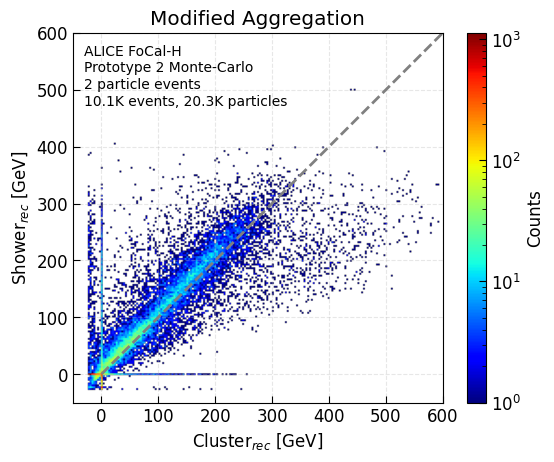

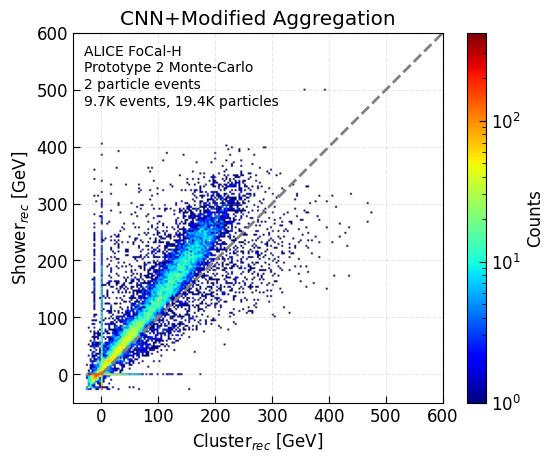

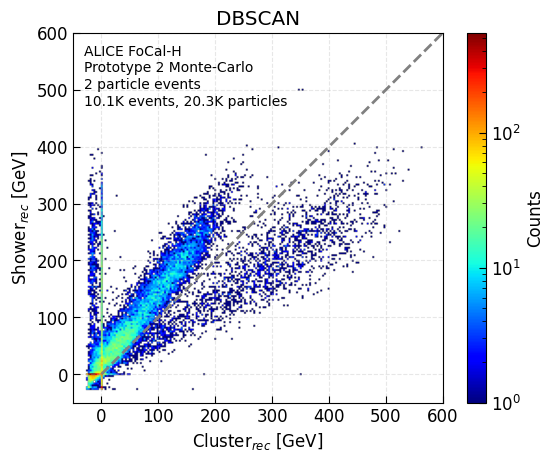

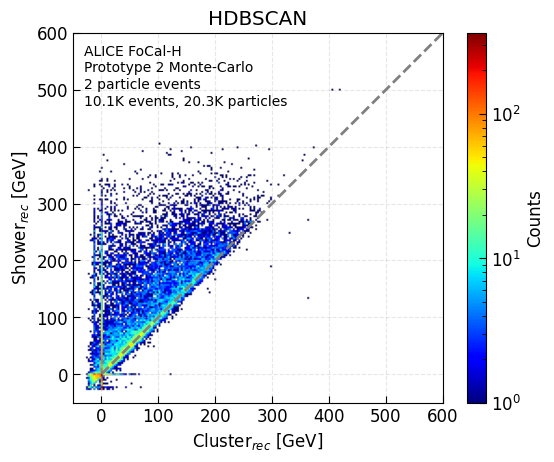

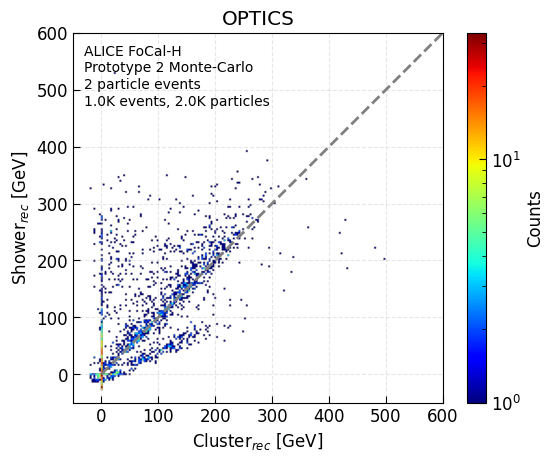

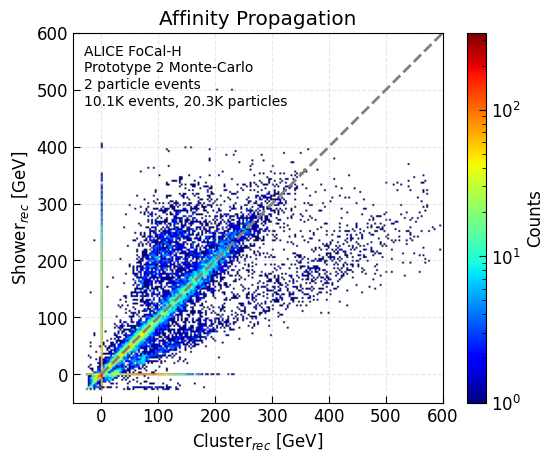

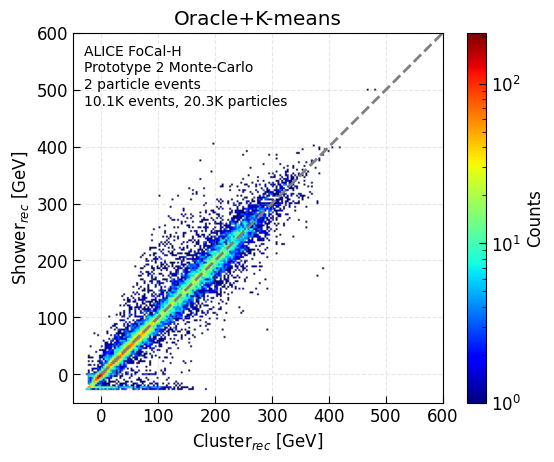

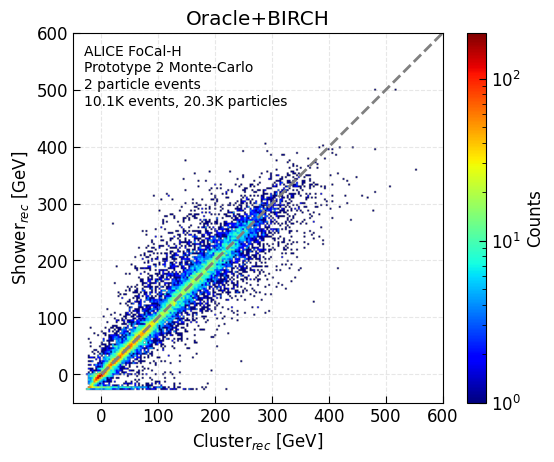

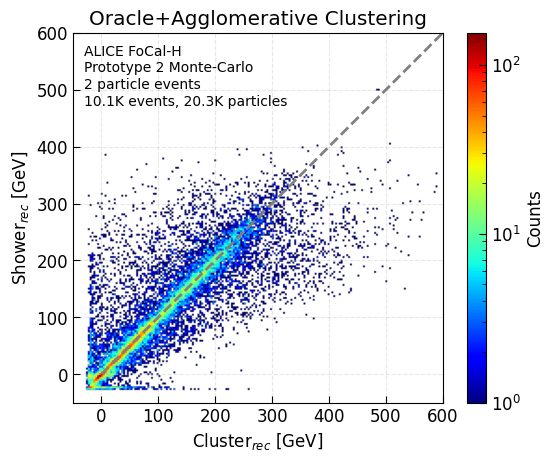

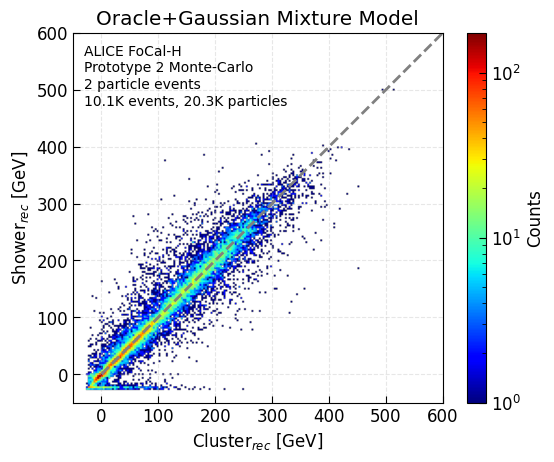

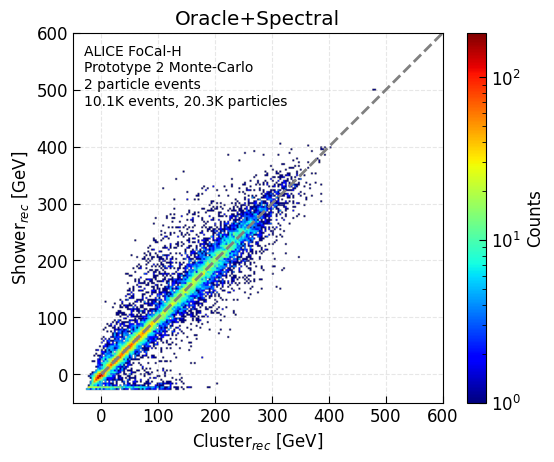

In [5]:
for key,item in evals.items():
    E_min = 0
    E_max = 600
#    fig,ax = plt.subplots(figsize=(6,6))
    fig,ax = plt.subplots()
    Nbins = 200
    data = load_bundle(evals[key])
    im,norm = migration_matrix(data, Nbins=Nbins, E_min=E_min, E_max=E_max, ax=ax, particles=2)
    mask = data["eval"]["particles"] == 2
    Nevents = len(data["eval"]["particles"][mask])
    Nparticles = data["eval"]["particles"][mask].sum()
    fig.colorbar(im, ax=ax, label="Counts")
    ax.set_aspect("equal")
    ax.set_xlabel("Cluster$_{rec}$ [GeV]")
    ax.set_ylabel("Shower$_{rec}$ [GeV]")
    ax.set_title(f"{item["name"]}")
    #ax.text(0.03, 0.95, f"{item["name"]}", transform=plt.gca().transAxes, ha="left", va="center")
    ax.text(0.03, 0.95, "ALICE FoCal-H", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.905, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.861, f"2 particle events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.815, f"{format_with_suffix(Nevents)} events, {format_with_suffix(Nparticles)} particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    fig.savefig(f"{evals[key]["name_short"]}_mig_2P.png", bbox_inches="tight")


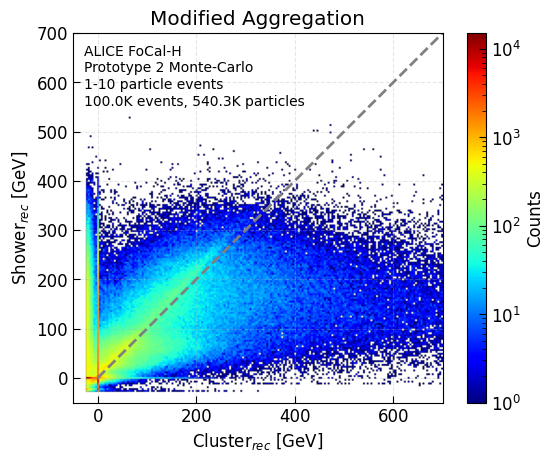

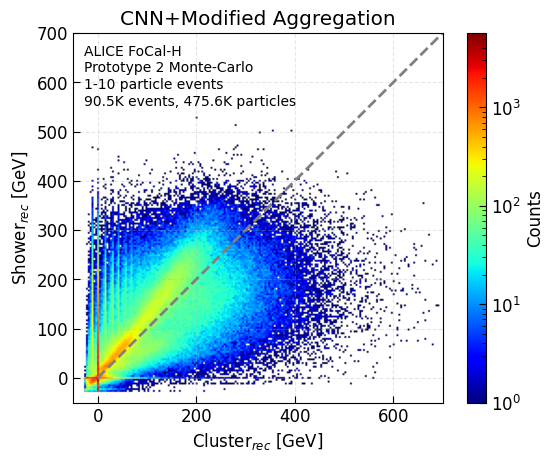

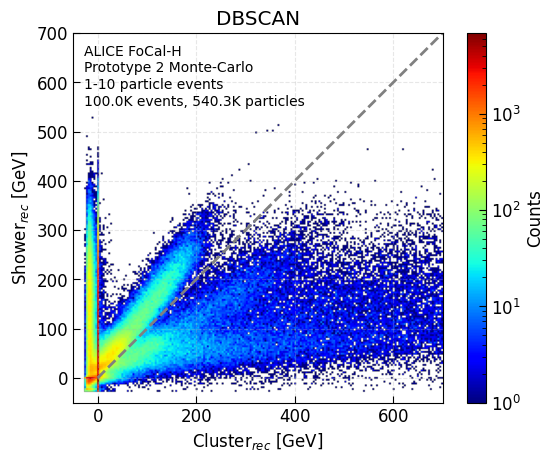

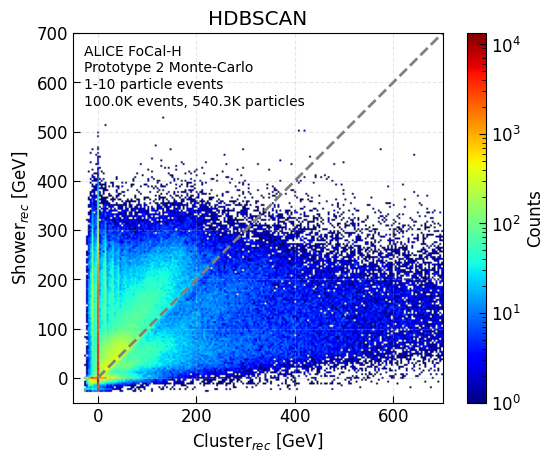

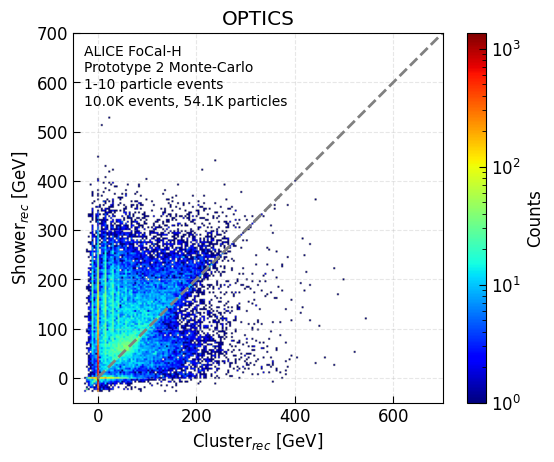

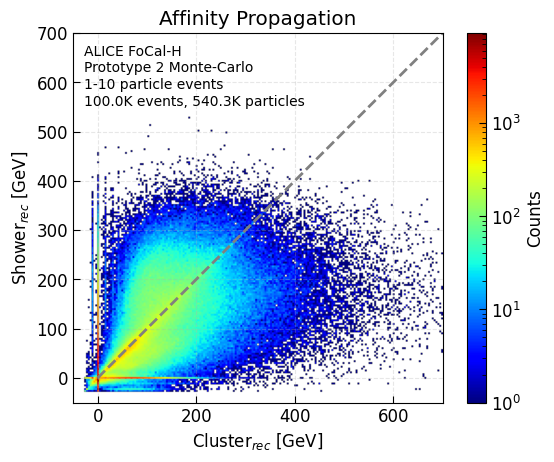

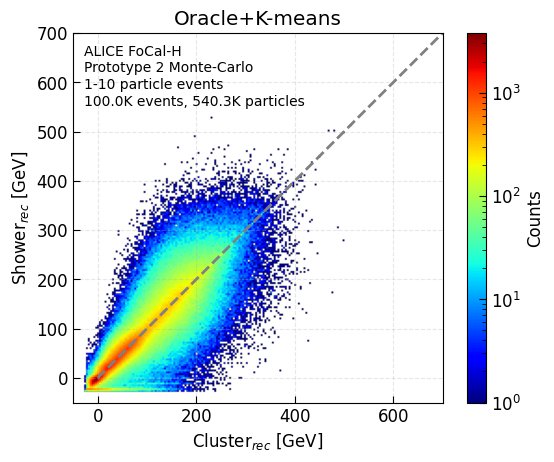

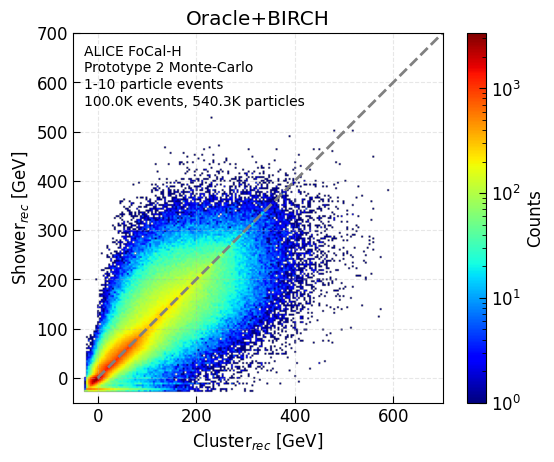

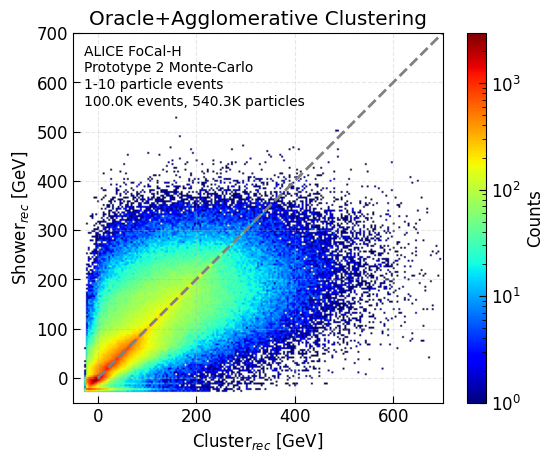

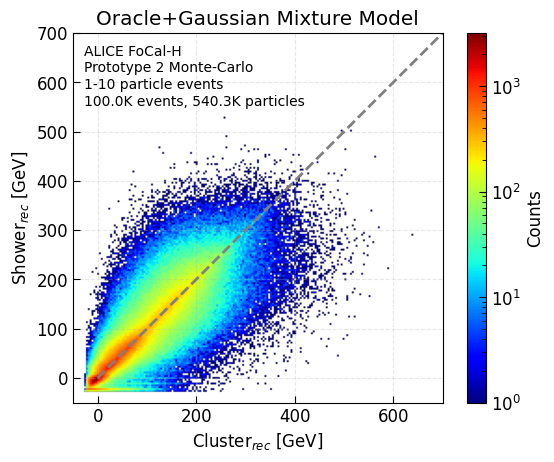

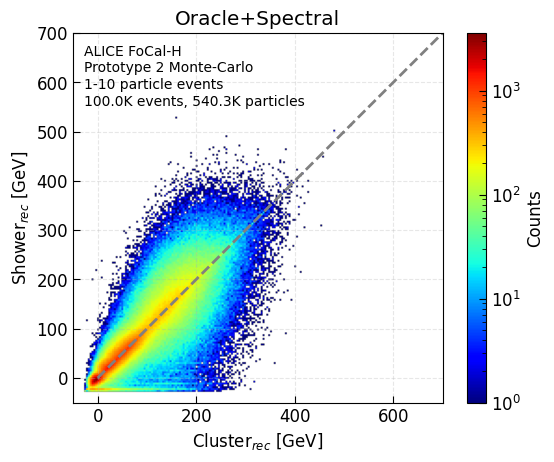

In [6]:
for key,item in evals.items():
    E_min = 0
    E_max = 700
#    fig,ax = plt.subplots(figsize=(6,6))
    fig,ax = plt.subplots()
    Nbins = 200
    data = load_bundle(evals[key])
    im,norm = migration_matrix(data, Nbins=Nbins, E_min=E_min, E_max=E_max, ax=ax, particles=None)
    Nevents = len(data["eval"]["particles"])
    Nparticles = data["eval"]["particles"].sum()
    fig.colorbar(im, ax=ax, label="Counts")
    ax.set_aspect("equal")
    ax.set_xlabel("Cluster$_{rec}$ [GeV]")
    ax.set_ylabel("Shower$_{rec}$ [GeV]")
    ax.set_title(f"{item["name"]}")
    #ax.text(0.03, 0.95, f"{item["name"]}", transform=plt.gca().transAxes, ha="left", va="center")
    ax.text(0.03, 0.95, "ALICE FoCal-H", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.905, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.861, f"1-10 particle events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.815, f"{format_with_suffix(Nevents)} events, {format_with_suffix(Nparticles)} particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    fig.savefig(f"{evals[key]["name_short"]}_mig_all.png", bbox_inches="tight")    


In [159]:
def match_com(indices, label_coms, tag_coms):
    x = []
    y = []
    err = 0
    for m in indices:
        if m[0] == -1:
            x.append((err,tag_coms[m[1]][0]))
            y.append((err,tag_coms[m[1]][1]))
        elif m[1] == -1:
            x.append((label_coms[m[0]][0],err))
            y.append((label_coms[m[0]][1],err))
        else:
            x.append((label_coms[m[0]][0],tag_coms[m[1]][0]))
            y.append((label_coms[m[0]][1],tag_coms[m[1]][1]))
    return x,y

def migration_matrix_pos(data, Nbins, E_min, E_max, ax=None, particles=None):

    if ax==None:
        fig,ax = plt.subplots()

    xx = []
    yy = []
    for i,e in enumerate(data["eval"]["matched_indices"]):
        if particles is not None:
            if data["eval"]["particles"][i] != particles:
                continue
        x_match, y_match = match_com(data["eval"]["matched_indices"][i], data["eval"]["label_coms"][i], data["eval"]["tag_coms"][i])
        for xm in x_match:
            xx.append(xm)
        for ym in y_match:
            yy.append(ym)
    xx = np.array(xx)
    yy = np.array(yy)
    
    """    
    pairs_list = []
    if particles is not None:
        for i,e in enumerate(data["eval"]["particles"]):
            if e == particles:
                pairs_list.append(data["eval"]["energy_pairs"][i])
        pairs = np.concatenate(pairs_list)
    else:
        pairs = np.concatenate(data["eval"]["energy_pairs"])
    """
    
    bins = np.linspace(E_min, E_max, Nbins)
    migration_matrix, xedges, yedges = np.histogram2d(
        xx[:,1], xx[:,0], bins=[bins, bins]
    )
    norm = colors.LogNorm(vmin=1, vmax=migration_matrix.max())
    #plt.figure(figsize=(8, 6))
    im = ax.imshow(
        migration_matrix.T,  # Transpose to match the orientation of true vs reconstructed
        origin="lower",
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect="auto",
        cmap="jet",
        norm=norm,
    )
    ax.grid(which="both", linestyle="--", alpha=0.3)
    ax.plot([E_min,E_max], [E_min,E_max], linestyle="--", linewidth=2, color="grey", alpha=1)
    return im, norm

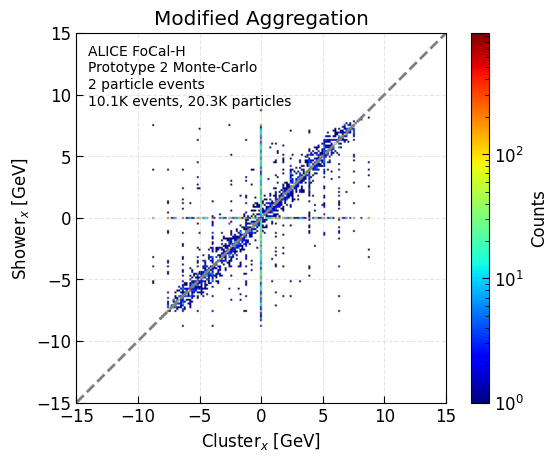

In [160]:
for key,item in evals.items():
    E_min = -15
    E_max = 15
#    fig,ax = plt.subplots(figsize=(6,6))
    fig,ax = plt.subplots()
    Nbins = 200
    data = load_bundle(evals[key])
    im,norm = migration_matrix_pos(data, Nbins=Nbins, E_min=E_min, E_max=E_max, ax=ax, particles=2)
    mask = data["eval"]["particles"] == 2
    Nevents = len(data["eval"]["particles"][mask])
    Nparticles = data["eval"]["particles"][mask].sum()
    fig.colorbar(im, ax=ax, label="Counts")
    ax.set_aspect("equal")
    ax.set_xlabel("Cluster$_{x}$ [GeV]")
    ax.set_ylabel("Shower$_{x}$ [GeV]")
    ax.set_title(f"{item["name"]}")
    #ax.text(0.03, 0.95, f"{item["name"]}", transform=plt.gca().transAxes, ha="left", va="center")
    ax.text(0.03, 0.95, "ALICE FoCal-H", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.905, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.861, f"2 particle events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    ax.text(0.03, 0.815, f"{format_with_suffix(Nevents)} events, {format_with_suffix(Nparticles)} particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
    #fig.savefig(f"{evals[key]["name_short"]}_mig_2P.png", bbox_inches="tight")
    break


In [80]:
for key,item in ma_data["eval"].items():
    print(key)

x
y
values
labels
energy
coms
adj
iadj
tags
separation_efficiency
energy_pairs
tag_coms
label_coms
matched_indices
data
efficiency
separation
vmeasure
coverage
particles
avg_energy


In [146]:
xx = []
yy = []
for i,e in enumerate(ma_data["eval"]["matched_indices"]):
    x_match, y_match = match_com(ma_data["eval"]["matched_indices"][i], ma_data["eval"]["label_coms"][i], ma_data["eval"]["tag_coms"][i])
    for xm in x_match:
        xx.append(xm)
    for ym in y_match:
        yy.append(ym)
    #break

xx = np.array(xx)
yy = np.array(yy)

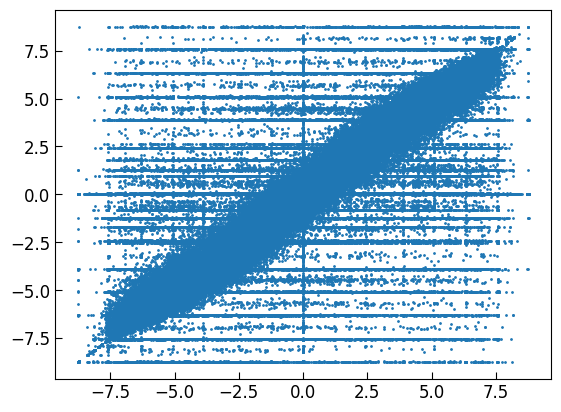

In [147]:
plt.scatter(xx[:,0], xx[:,1], s=1)

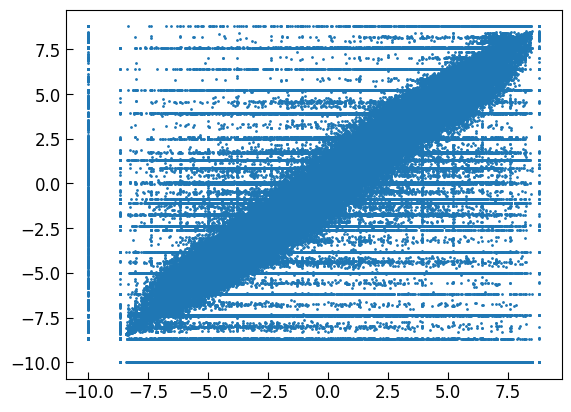

In [141]:
plt.scatter(yy[:,0], yy[:,1], s=1)